# Replication: Agency Conflicts and Cash: Estimates from a Dynamic Model
Author: Marcelo Ortiz (UPF & BSE).

This code replicates the main results in Nikolov & Whited (2014).

TO DO:
    (1) Figure 2: why capital depreciation δ reduces cash holding? in the original paper the relation is positive.


## List of Parameters:
     α,             # manager bonus
     β,             # manager equity share
     s,             # manager private benefit
     δ,             # capital depreciation
     λ,             # cost of issuing equity
     a,             # capital adjustment cost
     θ,             # curvature production function
     τ,             # corporate tax rate
     r,             # interest rate
     ϕ,             # cost of external finance
     dimz,          # dim of shock
     μ,             # log mean of AR process
     σ,             # s.d. deviation of innovation shocks
     ρ,             # persistence of AR process
     stdbound,      # standard deviation of AR process (set to 2)
     dimk,          # dimension of k, only works with odd numbers
     dimc,          # dimension of cash
     dimkp,         # dimension of future k
     dimcp):        # dimension of future cash
## Packing:
    α, β, s                         = param_manager     # Manager compensation
    δ, λ, a, θ, τ                   = param_inv         # Investment parameters
    r, ϕ                            = param_fin         # Financing Parameters                                       
    μ, σ, ρ, stdbound               = param_ar          # AR Parameters
    dimz, dimk, dimc, dimkp, dimcp  = param_dim         # dimensional Parameters

# Import and Settings

In [2]:
import math
import numpy as np
import numpy.typing as npt
import quantecon as qe
from interpolation.splines import eval_linear, CGrid
from numba import jit,prange
from multiprocessing import Pool
from itertools import repeat
import matplotlib.pyplot as plt
%matplotlib inline
%autosave 0

Autosave disabled


# 1. Replication of Optimal Policies ("Figure 1")

## 1.1 Grids and Value iteration functions

In [3]:
def set_vec(param_inv,param_fin, param_dim, param_manager,z_vec):   
    """
    Compute the vector of capital stock (around the steady-state) and cash (up to k steady state).
    Dimension: k_vec=[dimk , 1]; idem for the rest.
    """
    δ, _, a, θ, τ                = param_inv
    r, _                         = param_fin
    _, dimk, dimc, dimkp, dimcp  = param_dim
    α, β, s                      = param_manager 
    kstar = ((θ*(1-τ))/(r+δ))**(1/(1-θ))
    #kstar=2083.6801320704803
    # Set up the vectors
    
    k_vec  = np.reshape(np.linspace(0.01*kstar, 5*kstar,dimk),(dimk,1))
    kp_vec = np.reshape(np.linspace(0.01*kstar, 5*kstar,dimkp),(dimkp,1))
    c_vec  = np.reshape(np.linspace(0.0, kstar, dimc),(dimc,1))
    cp_vec = np.reshape(np.linspace(0.0, kstar, dimcp),(dimcp,1))
    return  [k_vec, kp_vec, c_vec, cp_vec, kstar]    

def trans_matrix(param_ar,param_dim):
    """
    Set the State vector for the productivity shocks Z and transition matrix.
    Dimension: z_vec =[dimZ , 1]; z_prob_mat=[dimz , dimZ] // Remember, sum(z_prob_mat[i,:])=1.
    """
    μ, σ, ρ, stdbound = param_ar
    dimz, dimk,*_     = param_dim
    
    mc          = qe.markov.approximation.tauchen(ρ,σ,μ,stdbound,dimz)
    z_vec       = mc.state_values
    Pi          = mc.P
    z_vec       = z_vec.reshape(dimz,1)
    z_vec       = np.e**(z_vec)
    z_prob_mat  = Pi.reshape(dimz,dimz)
    return [z_vec, z_prob_mat]

@jit(nopython=True,parallel=True)
def rewards_grids(param_manager,param_inv, param_fin,param_dim,z_vec,k_vec,c_vec):
    """
    Compute the manager's and shareholders' cash-flows  R and D, respectively, 
    for every (k_t, k_t+1, c_t, c_t+1) combination and every productivity shocks.
    """            
    α, β, s                         = param_manager     # Manager compensation
    δ, λ, a, θ, τ                   = param_inv         # Investment parameters
    r, ϕ                            = param_fin         # Financing Parameters                                       
    dimz, dimk, dimc, dimkp, dimcp  = param_dim         # dimensional Parameters                    
    
    R = np.zeros((dimk, dimkp, dimc, dimcp, dimz))
    D = np.zeros((dimk, dimkp, dimc, dimcp, dimz))
    inv:float
    d:float
    rw:float
    print("Computing reward matrix")
    for i_k in prange(dimk):
        for i_kp in range(dimkp):
            for i_c in range(dimc):
                for i_cp in range(dimcp):
                    for i_z in range(dimz):
                        inv                          = np.take(kp_vec[i_kp]-(1-δ)*k_vec[i_k],0)                          
                        d                            = np.take((1-τ)*(1-(α+s))*z_vec[i_z]*k_vec[i_k]**θ + δ*k_vec[i_k] *τ - inv - 0.5*a*((inv/k_vec[i_k] )**2)*k_vec[i_k]-cp_vec[i_cp] + c_vec[i_c]*(1+r*(1-τ))*(1-s),0)        
                        if d>=0:
                            D[i_k, i_kp, i_c, i_cp, i_z] = d
                        else:
                            D[i_k, i_kp, i_c, i_cp, i_z] = d*(1+ϕ)
                        rw                              = np.take((α+s)*z_vec[i_z]*k_vec[i_k]**θ + s*c_vec[i_c]*(1+r) + β*D[i_k, i_kp, i_c, i_cp, i_z] ,0)   
                        R[i_k, i_kp, i_c, i_cp, i_z]   = rw 
    print("Computing reward matrix - Done")                  
    return [R, D]
    
@jit(nopython=True,parallel=True)
def continuation_value(param_dim:npt.ArrayLike,U:npt.ArrayLike,z_prob_mat:npt.ArrayLike,grid:npt.ArrayLike,grid_interp:npt.ArrayLike):
    """
    Compute "Continuation Value" for every possible future state of nature (kp,cp,z).
    The "continuation value" is defined as: E[U(kp,cp,zp)]=sum{U(kp,cp,zp)*Prob(zp,p)}
    """
    dimz, dimk, dimc, dimkp, dimcp  = param_dim         # dimensional Parameters 
    cont_value=np.zeros((dimkp,dimcp,dimz))
    ztrans=np.zeros((1,dimz))    
    if (dimc==dimcp and dimk ==dimkp):
        for ind_z in prange(dimz):
            ztrans=np.transpose(z_prob_mat[ind_z, :])
            for i_k in range(dimk):
                for i_c in range(dimc):
                    cont_value[i_k,i_c,ind_z] = np.dot(ztrans, U[i_k,i_c,:])
    else:
        Uinter=eval_linear(grid,U,grid_interp)
        Uinter=Uinter.reshape((dimkp,dimcp,dimz))
        for ind_z in prange(dimz):
            ztrans=np.transpose(z_prob_mat[ind_z, :])
            for i_kpp in range(dimkp):
                for i_cpp in range(dimcp):
                    cont_value[i_kpp,i_cpp,ind_z]= np.dot(ztrans,Uinter[i_kpp,i_cpp,:])
    return cont_value

def bellman_operator(param_dim:npt.ArrayLike,param_fin:npt.ArrayLike,U:npt.ArrayLike,R:npt.ArrayLike,z_prob_mat:npt.ArrayLike,grid:npt.ArrayLike,grid_interp:npt.ArrayLike,i_kp:npt.ArrayLike, i_cp:npt.ArrayLike):
    """
     Second, identify max policy and save it.
     For each current state of nature (k,c,z), find the policy {kp,cp} that maximizes RHS: U(k,c,z) + E[U(kp,cp,zp)].
     Once found it, update the value of U in this current state of nature with the one generated with the optimal policy
     and save the respective optimal policy (kp,cp) for each state of nature (k,c,z).
    """
    dimz, dimk, dimc, dimkp, dimcp  = param_dim         # dimensional Parameters
    r, _                            = param_fin 
    c_value                         = continuation_value(param_dim,U,z_prob_mat,grid,grid_interp)
    RHS=np.empty((dimkp,dimcp))
    for (i_z, z) in enumerate(z_vec):
        for (i_k, k) in enumerate(k_vec):
            for (i_c, c) in enumerate(c_vec):
                RHS                 = R[i_k, :, i_c, :, i_z] + (1/(1+r))*c_value[:,:,i_z]
                i_kc                = np.unravel_index(np.argmax(RHS,axis=None),RHS.shape)           # the index of the best expected value for each kp,cp,z combination.    
                U[i_k, i_c, i_z]    = RHS[i_kc]                                       # update U with all the best expected values. 
                i_kp[i_k, i_c, i_z] = i_kc[0]
                i_cp[i_k, i_c, i_z] = i_kc[1]
    return [U,i_kp,i_cp ]

def value_iteration(param_dim:npt.ArrayLike,param_fin:npt.ArrayLike,R:npt.ArrayLike,z_prob_mat:npt.ArrayLike,k_vec:npt.ArrayLike,c_vec:npt.ArrayLike,z_vec:npt.ArrayLike,kp_vec:npt.ArrayLike,cp_vec:npt.ArrayLike,diff=1,tol=1e-6,imax=1500):
        """
        # Value Iteration on Eq 6.
        """
        dimz, dimk, dimc, dimkp, dimcp  = param_dim 
        U    = np.zeros((dimk, dimc, dimz))
        i_kp = np.empty((dimk, dimc, dimz),dtype=float)
        i_cp = np.empty((dimk, dimc, dimz),dtype=float)
        grid = CGrid(k_vec.reshape(dimk),c_vec.reshape(dimc),z_vec.reshape(dimz))
        grid_interp=np.zeros((0,3))
        for i_kpp in range(dimkp):
             for i_cpp in range(dimcp):
                for i_zp in range(dimz):
                    new_point=np.array([kp_vec[i_kpp], cp_vec[i_cpp], z_vec[i_zp]]).reshape((1,3))
                    grid_interp = np.append(grid_interp,new_point,axis=0)
        #grid_interp = [np.array([kp_vec[i_kpp], cp_vec[i_cpp], z_vec[i_zp]]).reshape((1,3)) for i_kpp in range(dimkp) for i_cpp in range(dimcp) for i_zp in range(dimz)]
        print("Iteration start")                   
        for i in range(imax):
            U_old          = np.copy(U)
            [Up,i_kp,i_cp ]= bellman_operator(param_dim,param_fin,U, R,z_prob_mat,grid,grid_interp, i_kp, i_cp)         
            diff           = np.max(np.abs(Up-U_old))
            if i==1: 
                print(f"Error at iteration {i} is {diff}.") 
            if i==500: 
                print(f"Error at iteration {i} is {diff}.")           
            if diff < tol:
                print(f"Solution found at iteration {i}.")   
                break
            if i == imax:
                print("Failed to converge!")        
        # Evaluating the optimal policies using the indexes obtained in the iterations.
        Kp=np.zeros((dimk, dimc, dimz))
        Cp=np.zeros((dimk, dimc, dimz))
        for index,value in  np.ndenumerate(i_kp):
            index2=int(value)
            Kp[index]=kp_vec[index2]
        for index,value in  np.ndenumerate(i_cp):
            index2=int(value)
            Cp[index]=cp_vec[index2]
            
        return [U,Kp,Cp,i_kp,i_cp]

## 1.2 Computation Optimal Policies 

In [4]:
param_manager     = (0.751/100, 0.051, 0.101/1000) # (α, β, s) 
param_inv         = (0.130, 0, 1.278, 0.773 , 0.2) # (δ, λ, a, θ, τ)   
param_fin         = (0.011, 0.043)                 # (r, ϕ=0.043)
param_ar          = (0, 0.262, 0.713, 4)           # (μ, σ, ρ, stdbound)
_nk               = 5                              # intermediate points in the capital grid
_nc               = 5                              # intermediate points in the cash grid
(dimz, dimk, dimc)=(11,25,7)
param_dim         = (dimz,dimk,dimc,dimk*_nk,dimc*_nc)         # wrapping dimensional parameters: (dimz, dimk, dimc, dimkp, dimcp)

In [5]:
[z_vec, z_prob_mat]                  = trans_matrix(param_ar,param_dim)
[k_vec, kp_vec, c_vec, cp_vec, kstar]= set_vec(param_inv, param_fin, param_dim, param_manager,z_vec)
[R, D]                               = rewards_grids(param_manager,param_inv, param_fin,param_dim,z_vec,k_vec,c_vec)
[Up,Kp,Cp,i_kp,i_cp]                 = value_iteration(param_dim,param_fin,R,z_prob_mat,k_vec,c_vec,z_vec,kp_vec,cp_vec)

Computing reward matrix
Computing reward matrix - Done
Iteration start
Error at iteration 1 is 66.05364114572461.
Error at iteration 500 is 0.027390578490212647.
Solution found at iteration 1435.


## 1.3 Ploting "Figure 1"

In [6]:
# Plotting Policy function
def plot_policy_function(param_manager,param_inv,param_fin,param_dim,z_vec,k_vec,c_vec,Kp,Cp):
    α, β, s                         = param_manager     # Manager compensation
    δ, λ, a, θ, τ                   = param_inv         # Investment parameters
    r, ϕ                            = param_fin         # Financing Parameters                                       
    dimz, dimk, dimc, dimkp, dimcp  = param_dim         # dimensional Parameters
    
    I_p=np.empty((dimk, dimc,dimz))        
    CRatio_P=np.empty((dimk,dimc,dimz))
    CF_p=np.empty((dimk, dimc,dimz))
    F_p=np.empty((dimk, dimc,dimz))
    
    for z in range(dimz):
        for c in range(dimc):
            for k in range(dimk):            
                CF_p[k,c,z]       = ((1-τ)*z_vec[z]*k_vec[k]**θ)/k_vec[k]
                I                 = (Kp[k,c,z]-(1-δ)*k_vec[k])
                I_p[k,c,z]        = I/k_vec[k]
                CRatio_P[k,c,z]   = Cp[k,c,z]/(c_vec[c]+k_vec[k])
                d                 = (1-τ)*(1-(α+s))*z_vec[z]*k_vec[k]**θ + δ*k_vec[k]*τ - I  - 0.5*a*((I/k_vec[k])**2)*k_vec[k]  - Cp[k,c,z] +c_vec[c]*(1+r*(1-τ))*(1-s)
                F_p[k,c,z]        = d/(c_vec[c]+k_vec[k]) if d>=0 else d*(1+ϕ)/(c_vec[c]+k_vec[k])  
                 
    [i_kstar, j_kstar] = np.unravel_index(np.argmin(np.abs(kstar-k_vec),axis=None),k_vec.shape)       #the plots are with kstar, for different levels of c and z    
    logz=np.log(z_vec)
    cmed_plot=math.floor(dimc/2)
    
    fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1,figsize=(15, 15))
    ax1.plot(logz,CF_p[i_kstar,1,:] , label='Low Cash ratio',linestyle = 'dashed', c='b')
    ax1.plot(logz,CF_p[i_kstar,cmed_plot,:] , label='Medium Cash ratio',linestyle = 'solid', c='b')
    ax1.plot(logz,CF_p[i_kstar,dimc-1,:] , label='High Cash ratio',linestyle = 'dotted', c='b')
    ax1.set_xlabel("Log productivity shock")
    ax1.set_ylabel("Cash Flow / Capital")
    ax1.legend()
    
    ax2.plot(logz,I_p[i_kstar,1,:] , label='Low Cash ratio',linestyle = 'dashed', c='b')
    ax2.plot(logz,I_p[i_kstar,cmed_plot,:] , label='Medium Cash ratio',linestyle = 'solid', c='b')
    ax2.plot(logz,I_p[i_kstar,dimc-1,:] , label='High Cash ratio',linestyle = 'dotted', c='b')
    ax2.set_xlabel("Log productivity shock")
    ax2.set_ylabel("Investment / Capital")
    #ax2.legend()
    #
    ax3.plot(logz,CRatio_P[i_kstar,1,:] , label='Low Cash ratio',linestyle = 'dashed', c='b')
    ax3.plot(logz,CRatio_P[i_kstar,cmed_plot,:] , label='Medium Cash ratio',linestyle = 'solid', c='b')
    ax3.plot(logz,CRatio_P[i_kstar,dimc-1,:] , label='High Cash ratio',linestyle = 'dotted', c='b')
    ax3.set_xlabel("Log productivity shock")
    ax3.set_ylabel("Cash / Assets")
    #ax3.legend()
    
    ax4.plot(logz,F_p[i_kstar,1,:] , label='Low Cash ratio',linestyle = 'dashed', c='b')
    ax4.plot(logz,F_p[i_kstar,cmed_plot,:] , label='Medium Cash ratio',linestyle = 'solid', c='b')
    ax4.plot(logz,F_p[i_kstar,dimc-1,:] , label='High Cash ratio',linestyle = 'dotted', c='b')
    ax4.set_xlabel("Log productivity shock")
    ax4.set_ylabel("External FIn / Assets")
    #ax4.legend()
    
    plt.show()
    fig.savefig("Figure1.png", bbox_inches='tight', dpi=600)

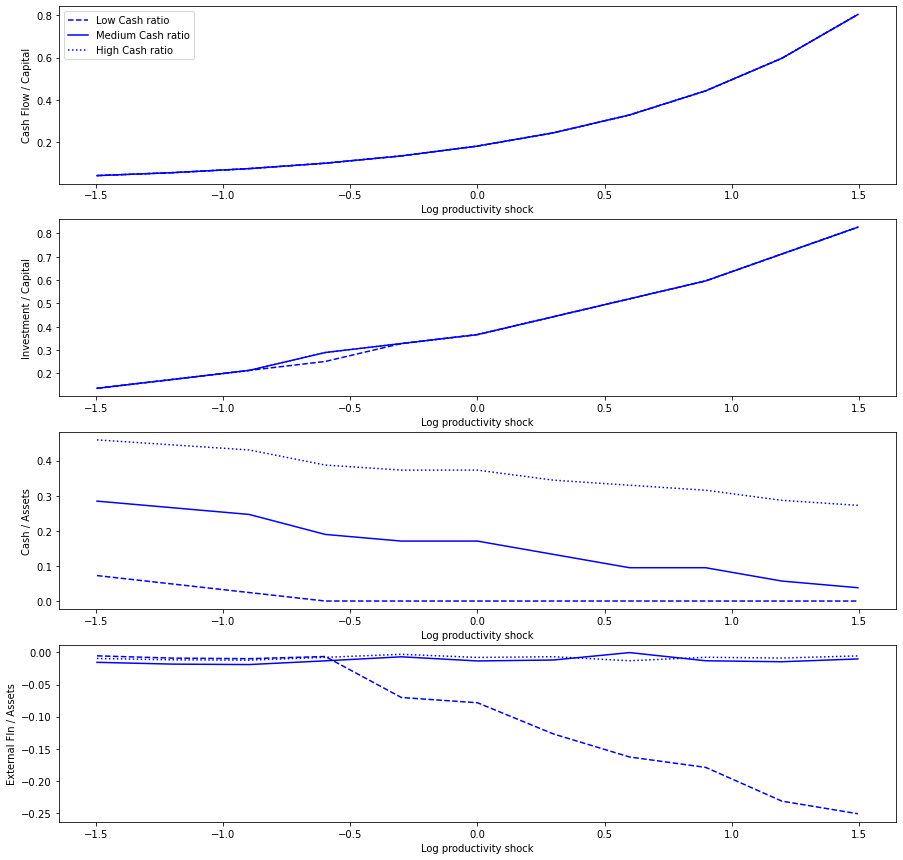

In [7]:
plot_policy_function(param_manager,param_inv,param_fin,param_dim,z_vec,k_vec,c_vec,Kp,Cp)

# 2. Replication of Comparative Statistics ("Figure 2")

## 2.1 Simulation function

In [8]:
def model_sim(z_vec,z_prob_mat,kstar ,kp_vec, cp_vec, Kp, Cp, N, Ttot,Terg=200):
        """
        # Model simulation.
        """
        mc  = qe.MarkovChain(z_prob_mat)
        E   = mc.simulate(ts_length=Ttot,num_reps=N).T

        Ksim = np.zeros((Ttot, N))
        Csim = np.zeros((Ttot, N))
        # the simulations start with the value of the central element in k_vec and c_vec,
        Ksim[0, :]=kstar*np.ones((1, N))

        given_value = 0
        search_list = []
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        for n in range(N):
            for t in range(1,Ttot):
                # find previous K
                given_value=Ksim[t-1, n]
                search_list=k_vec
                closest_k=min(search_list, key=absolute_difference_function)
                closest_k_posicion=np.take(np.where(search_list==closest_k),0)
                # find previous C
                given_value=Csim[t-1, n]
                search_list=c_vec
                closest_c=min(search_list, key=absolute_difference_function)
                closest_c_posicion=np.take(np.where(search_list==closest_c),0)
                # find previus shock
                id_z = E[t-1,n]
                # compute the respective policy depending of the position in t-1
                Ksim[t, n] = Kp[closest_k_posicion,closest_c_posicion, id_z] 
                Csim[t, n] = Cp[closest_k_posicion,closest_c_posicion, id_z]
        # Remove the burning period
        Ksim=Ksim[(Terg+1):-1, :]
        Csim = Csim[(Terg+1):-1, :]
        
        print()
        print("Quick simulation check: p lb, min(psim), max(psim), p ub \n")
        print(f"K = {k_vec[0]} {np.min(Ksim)} {np.max(Ksim)} {k_vec[-1]} \n")
        print(f"C = {c_vec[0]} {np.min(Csim)} {np.max(Csim)} {c_vec[-1]} \n")
        print()
       
        return [Ksim, Csim,E]

Fast check of simulation boundaries:

In [9]:
[sim_K, sim_C,E]                     = model_sim(z_vec,z_prob_mat,kstar,kp_vec, cp_vec, Kp, Cp,N=5, Ttot=1_000)


Quick simulation check: p lb, min(psim), max(psim), p ub 

K = [6.73621157] 1497.6662650521046 3368.1057866890524 [3368.10578669] 

C = [0.] 0.0 653.8087703572866 [673.62115734] 




## 2.2 Computation comparative statistics
The output of this cell is quite long since it shows some prints for the value iteration process and then more prints to check whether the simulations are touching the borders of the grids.

To see the figure, scroll down to the bottom.

In [10]:
def run_comparative_stats(variable,param_iter):
    param_manager     = (0.751/100, 0.051, 0.101/1000) # (α, β, s) 
    param_inv         = (0.130, 0, 1.278, 0.773 , 0.2) # (δ, λ, a, θ, τ)   
    param_fin         = (0.011, 0.043)                 # (r, ϕ=0.043)
    param_ar          = (0, 0.262, 0.713, 4)           # (μ, σ, ρ, stdbound)
    _nk               = 5                              # intermediate points in the capital grid
    _nc               = 5                              # intermediate points in the cash grid
    (dimz, dimk, dimc)=(11,25,7)
    param_dim         = (dimz,dimk,dimc,dimk*_nk,dimc*_nc)         # wrapping dimensional parameters: (dimz, dimk, dimc, dimkp, dimcp)
    
    if variable =='ϕ':
        param_fin                   = (0.011, param_iter)                 # (r, ϕ)
    elif variable=='θ':     
        param_inv                   = (0.130, 0, 1.278, param_iter, 0.2)  # (δ, λ, a, θ, τ)
    elif variable=='a':     
        param_inv                   = (0.130, 0, param_iter, 0.773 , 0.2) # (δ, λ, a, θ, τ)
    elif variable=='δ':     
        param_inv                   = (param_iter, 0, 1.278,0.773 , 0.2)  # (δ, λ, a, θ, τ)
    elif variable=='σ':
        param_ar                    = (0, param_iter, 0.713, 4)           # (μ, σ, ρ, stdbound)
    elif variable=='ρ':
        param_ar                    = (0, 0.262, param_iter, 4)           # (μ, σ, ρ, stdbound)
    elif variable=='α':
        param_manager               = (param_iter,0.051, 0.101/1000)      # (α, β, s)
    elif variable=='s':
        param_manager               = (0.751/100,0.051, param_iter)       # (α, β, s)
    elif variable=='β':
        param_manager               = (0.751/100,param_iter, 0.101/1000)  # (α, β, s)      
    else:
        print("not known variable")
        breakpoint()
    [z_vec, z_prob_mat]                  = trans_matrix(param_ar,param_dim)
    [k_vec, kp_vec, c_vec, cp_vec, kstar]= set_vec(param_inv, param_fin, param_dim, param_manager,z_vec)   
    [R, D]                               = rewards_grids(param_manager,param_inv, param_fin,param_dim,z_vec,k_vec,c_vec)
    [Up,Kp,Cp,i_kp,_]                    = value_iteration(param_dim,param_fin,R,z_prob_mat,k_vec,c_vec,z_vec,kp_vec,cp_vec)
    [sim_K, sim_C,_]                     = model_sim(z_vec,z_prob_mat,kstar,kp_vec, cp_vec, Kp, Cp,num_reps, ts_length)
    sim_Cratio                           = sim_C/(sim_K+sim_C)       
    sim_Cratio_av                        = np.mean(sim_Cratio)

    return sim_Cratio_av

In [11]:
num_reps  = 1
ts_length = 10_000
num_simulation_per_param=5

# Financing parameters
ϕ_vec = np.linspace(0,0.25,num_simulation_per_param) 
# Investment parameters
θ_vec = np.linspace(0.5,0.9,num_simulation_per_param) 
a_vec = np.linspace(0,1.5,num_simulation_per_param) 
δ_vec = np.linspace(0.05,0.2,num_simulation_per_param) 
# Manager parameters
β_vec = np.linspace(0.01,0.1,num_simulation_per_param) 
α_vec = np.linspace(0,0.01,num_simulation_per_param) 
s_vec = np.linspace(0,0.02/100,num_simulation_per_param)
# AR parameters
σ_vec = np.linspace(0.1,0.5,num_simulation_per_param)  
ρ_vec = np.linspace(0.5,0.75,num_simulation_per_param)

In [12]:
print("First column of plots: ϕ θ β")
with Pool() as pool:
    com_stat_cash = pool.starmap(run_comparative_stats, zip(repeat('ϕ'),ϕ_vec))     
with Pool() as pool2:
    com_stat_cash2 = pool2.starmap(run_comparative_stats, zip(repeat('θ'),θ_vec))  
with Pool() as pool3:
    com_stat_cash3 = pool3.starmap(run_comparative_stats, zip(repeat('β'),β_vec))   

print("Second column of plots: σ a α")
with Pool() as pool4:
    com_stat_cash4 = pool4.starmap(run_comparative_stats, zip(repeat('σ'),σ_vec))   
with Pool() as pool5:
    com_stat_cash5 = pool5.starmap(run_comparative_stats, zip(repeat('a'),a_vec))   
with Pool() as pool6:
    com_stat_cash6 = pool6.starmap(run_comparative_stats, zip(repeat('α'),α_vec))  

print("Third column of plots: ρ δ s")
with Pool() as pool7:
    com_stat_cash7 = pool7.starmap(run_comparative_stats, zip(repeat('ρ'),ρ_vec)) 
with Pool() as pool8:
    com_stat_cash8 = pool8.starmap(run_comparative_stats, zip(repeat('δ'),δ_vec)) # problem: opposite slope
with Pool() as pool9:
    com_stat_cash9 = pool9.starmap(run_comparative_stats, zip(repeat('s'),s_vec)) 

First column of plots: ϕ θ β
Computing reward matrixComputing reward matrixComputing reward matrixComputing reward matrix
Computing reward matrix



Computing reward matrix - Done
Computing reward matrix - Done
Computing reward matrix - Done
Computing reward matrix - Done
Computing reward matrix - Done
Iteration start
Iteration start
Iteration start
Iteration start
Iteration start
Error at iteration 1 is 66.05364114572461.
Error at iteration 1 is 66.05364114572461.
Error at iteration 1 is 66.05364114572461.
Error at iteration 1 is 66.05364114572461.
Error at iteration 1 is 66.05364114572461.
Error at iteration 500 is 0.02742097128543719.
Error at iteration 500 is 0.0273713031222087.
Error at iteration 500 is 0.027377662152503035.
Error at iteration 500 is 0.027373745630598023.
Error at iteration 500 is 0.027385496570104806.
Solution found at iteration 1434.
Solution found at iteration 1435.

Quick simulation check: p lb, min(psim), max(psim), p ub 

K = [6.73621157] 1253.6958926646766 

## 2.3 Plotting "Figure 2"

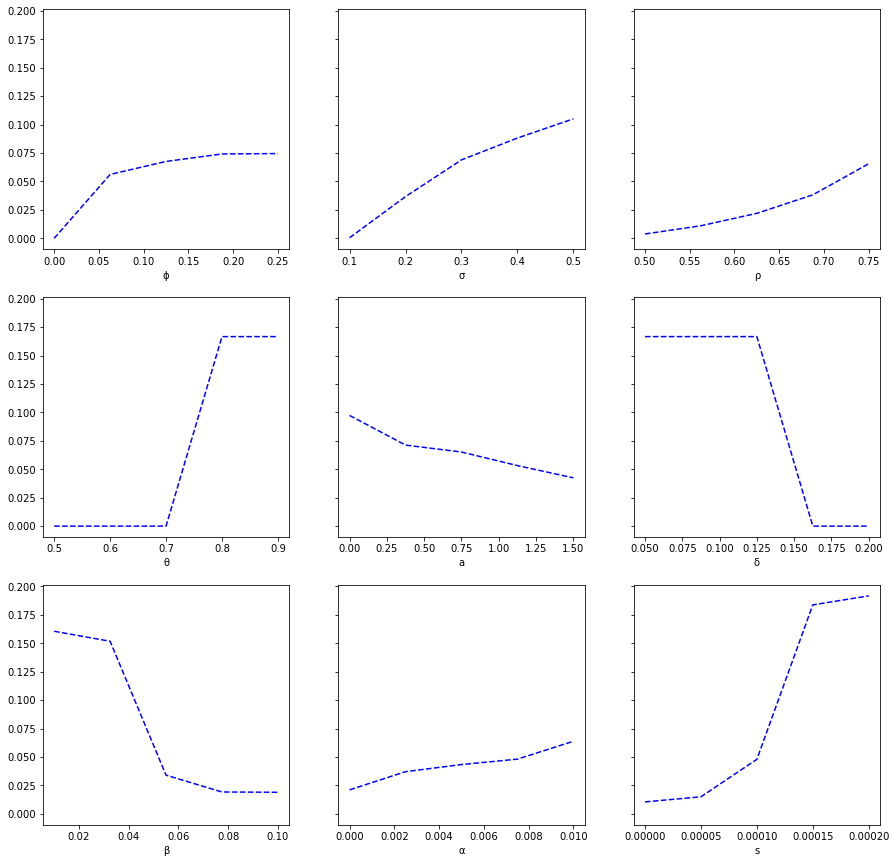

In [13]:
F2=fig, ((ax1, ax4, ax7), (ax2, ax5, ax8), (ax3, ax6, ax9)) = plt.subplots(3,3,sharey=True,figsize=(15, 15))
ax1.plot(ϕ_vec,com_stat_cash ,linestyle = 'dashed', c='b')
ax1.set_xlabel("ϕ")
ax2.plot(θ_vec,com_stat_cash2 ,linestyle = 'dashed', c='b')
ax2.set_xlabel("θ")
ax3.plot(β_vec,com_stat_cash3 ,linestyle = 'dashed', c='b')
ax3.set_xlabel("β")
ax4.plot(σ_vec,com_stat_cash4 ,linestyle = 'dashed', c='b')
ax4.set_xlabel("σ")
ax5.plot(a_vec,com_stat_cash5 ,linestyle = 'dashed', c='b')
ax5.set_xlabel("a")
ax6.plot(α_vec,com_stat_cash6 ,linestyle = 'dashed', c='b')
ax6.set_xlabel("α")
ax7.plot(ρ_vec,com_stat_cash7 ,linestyle = 'dashed', c='b')
ax7.set_xlabel("ρ")
ax8.plot(δ_vec,com_stat_cash8 ,linestyle = 'dashed', c='b')
ax8.set_xlabel("δ")
ax9.plot(s_vec,com_stat_cash9 ,linestyle = 'dashed', c='b')
ax9.set_xlabel("s")
plt.show()
fig.savefig("Figure2.png", bbox_inches='tight', dpi=600)

In [14]:
!jupyter nbconvert  "Nikolov&Whited2014.ipynb" --to html

[NbConvertApp] Converting notebook Nikolov&Whited2014.ipynb to html
[NbConvertApp] Writing 786584 bytes to Nikolov&Whited2014.html
